In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2023-04-14 18:51:22.215800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### The Experiment Setup
#### There will be 10 environment with different epsilon values, any of them consists of 1000 images = 10k images
#### 50k for trainnig 10k for testing

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
num_envs = 10
sample_per_env = 1000

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('Max val: '+str(np.max(x_train)))
#Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

env_sample_num = num_envs*sample_per_env
x_envs = x_train[0:env_sample_num]
y_envs = y_train[0:env_sample_num]
x_train = x_train[env_sample_num:]
y_train = y_train[env_sample_num:]
np.shape(y_train)


Max val: 255


(50000,)

In [9]:
type(x_train[0,0,0])
np.uint8(255)

255

In [10]:


# Load the data and split it between train and test sets
#(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print(y_train.shape)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 28, 28, 1)
50000 train samples
10000 test samples
(50000,)


In [11]:
x_envs = np.reshape(x_envs, (num_envs, -1, input_shape[0], input_shape[1]))

In [12]:
env1 = x_envs[0]


Text(0, 0.5, '# Occurence')

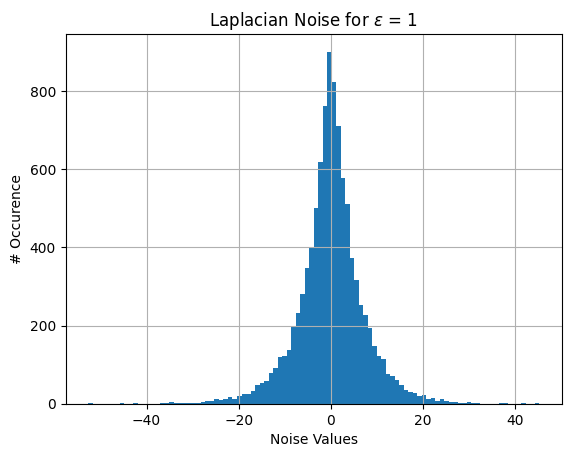

In [13]:
loc = 0
scale = 5
size = 10000
noise = np.random.laplace(loc,scale,size)
plt.hist(noise,100)
plt.title('Laplacian Noise for '+ r'$\epsilon$' +' = 1 ')
plt.grid()
plt.xlabel('Noise Values')
plt.ylabel('# Occurence')

In [14]:
def getGlobalSens(dataset):
    max_val = np.max(dataset)
    min_val = np.min(dataset)
    return np.abs(max_val - min_val)

def generateLaplacianNoise(epsilon, globalSens, size,loc=10):
    scale = globalSens/epsilon
    noise = np.random.laplace(loc, scale,size)
    return noise


In [15]:
num_repeats = 5
a = np.array([1, 2, 3, 4])
b = np.repeat(a,10)
c = np.reshape(b, (4,-1))
print(np.shape(c))
print(c)

(4, 10)
[[1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4]]


In [16]:
def getHardEnv(envData, hardnessLevelEnv = 0.5):
    epsilonEnv = 1/hardnessLevelEnv
    globalSensEnv = getGlobalSens(envData)
    envNoise = generateLaplacianNoise(epsilonEnv, globalSensEnv, np.shape(envData))
    noisyEnv = envData + envNoise
    # some hard parameters
    image_origin = 0
    image_max = 1
    
    # normalization
    nmin = np.min(np.reshape(noisyEnv, (np.shape(noisyEnv)[0],-1)), axis=1) 
    nmax = np.max(np.reshape(noisyEnv, (np.shape(noisyEnv)[0],-1)), axis=1) 
    nmin = np.reshape(np.repeat(nmin, np.shape(noisyEnv)[-1]*np.shape(noisyEnv)[-2]), np.shape(noisyEnv))
    nmax = np.reshape(np.repeat(nmax, np.shape(noisyEnv)[-1]*np.shape(noisyEnv)[-2]), np.shape(noisyEnv))
    
    noisyEnv = (noisyEnv - nmin + image_origin) / (nmax/image_max)
    return noisyEnv


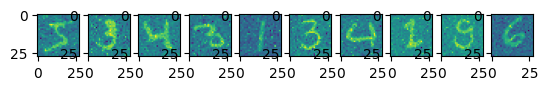

In [17]:
noisyEnv = getHardEnv(env1, 0.2)

# print(np.shape(tempnoise))
# print(np.shape(nmax))
# print(np.shape(nmin))
# print(np.shape(1-nmin))
plt.figure()
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(noisyEnv[i*10])

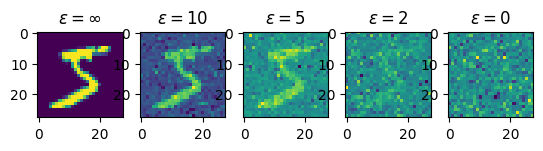

In [18]:
globalSens = getGlobalSens(env1)
epsilon = 10

noise_img = generateLaplacianNoise(epsilon, globalSens, np.shape(env1[0]))
noise_img2 = generateLaplacianNoise(epsilon/2, globalSens, np.shape(env1[0]))
noise_img3 = generateLaplacianNoise(2, globalSens, np.shape(env1[0]))
noise_img4 = generateLaplacianNoise(0.001, globalSens, np.shape(env1[0]))

noisy_img = noise_img + env1[0]
noisy_img2 = noise_img2 + env1[0]
noisy_img3 = noise_img3 + env1[0]
noisy_img4 = noise_img4 + env1[0]

noisy_img3 = noisy_img3 - np.min(noisy_img3)
noisy_img3 = noisy_img3 / np.max(noisy_img3)

plt.figure()
plt.subplot(1,5,1)
plt.title(r'$\epsilon=\infty$')
plt.imshow(env1[0])
plt.subplot(1,5,2)
plt.title(r'$\epsilon=10$')
plt.imshow(noisy_img)
plt.subplot(1,5,3)
plt.title(r'$\epsilon=5$')
plt.imshow(noisy_img2)
plt.subplot(1,5,4)
plt.title(r'$\epsilon=2$')
plt.imshow(noisy_img3)
plt.subplot(1,5,5)
plt.title(r'$\epsilon=0$')
plt.imshow(noisy_img4)


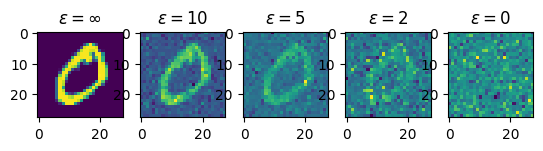

In [19]:
globalSens = getGlobalSens(env1)
epsilon = 10

noise_img = generateLaplacianNoise(epsilon, globalSens, np.shape(env1[0]))
noise_img2 = generateLaplacianNoise(epsilon/2, globalSens, np.shape(env1[0]))
noise_img3 = generateLaplacianNoise(2, globalSens, np.shape(env1[0]))
noise_img4 = generateLaplacianNoise(0.001, globalSens, np.shape(env1[0]))

noise_img_normalized = noise_img + np.min(np.min(noise_img))
noise_img_normalized = noise_img_normalized / np.max(np.max(noise_img))

noise_img_normalized2 = noise_img2 + np.min(np.min(noise_img2))
noise_img_normalized2 = noise_img_normalized2 / np.max(np.max(noise_img2))

noise_img_normalized3 = noise_img3 + np.min(np.min(noise_img3))
noise_img_normalized3 = noise_img_normalized3 / np.max(np.max(noise_img3))

noise_img_normalized4 = noise_img4 + np.min(np.min(noise_img4))
noise_img_normalized4 = noise_img_normalized4 / np.max(np.max(noise_img4))

noisy_img = noise_img + env1[1]
noisy_img2 = noise_img2 + env1[1]
noisy_img3 = noise_img3 + env1[1]
noisy_img4 = noisy_img4 + env1[1]

plt.figure()
plt.subplot(1,5,1)
plt.title(r'$\epsilon=\infty$')
plt.imshow(env1[1])
plt.subplot(1,5,2)
plt.title(r'$\epsilon=10$')
plt.imshow(noisy_img)
plt.subplot(1,5,3)
plt.title(r'$\epsilon=5$')
plt.imshow(noisy_img2)
plt.subplot(1,5,4)
plt.title(r'$\epsilon=2$')
plt.imshow(noisy_img3)
plt.subplot(1,5,5)
plt.title(r'$\epsilon=0$')
plt.imshow(noisy_img4)



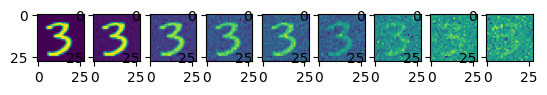

In [23]:
hardness_levels = np.array([0.001, 0.01, 0.04, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8])
plt.figure()
ct = 1
for hardness in hardness_levels:
    plt.subplot(1,len(hardness_levels), ct)
    ct +=1
    img = np.load('./hardEnvs/mnist_train_data_env_hardness_'+str(hardness)+'.npy')
    plt.imshow(img[0])